## Objective : test linear decision tree

In [1]:
import pandas as pd
import numpy as np
import warnings
from datetime import datetime, timedelta

from pylec.optimize.batteries import OptimizeBatteries
from pylec.forecast.manage import MultiModel
from pylec.forecast.pipelines import PipelineNoExog, PipelineZenith
from horizon.models import GAM, Perfect
from pylec.control.matchsurplus import MatchSurplus
from pylec.simulate import Simulation
from pylec.scenarios import PVGISQuoilin, describe

import plotly.express as px

layout = {
    'showlegend': False,
    'margin': {'b':10, 'l':10, 'r':10, 't':10},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2,  'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}
px.defaults.color_discrete_sequence = px.colors.qualitative.T10


def distribution_plots(errors, ecdf_only=False):
    if not ecdf_only:
        fig = px.histogram(errors, barmode="overlay", histnorm="percent", marginal="box")
        fig.data[0].update({"marker_opacity": 1.0})
        fig.data[1].update({"boxpoints": False})
        fig.data[2].update({"opacity": 0.7})
        fig.data[3].update({"boxpoints": False})
        fig.update_layout(layout, showlegend=True,
                          yaxis_title="Percentage [%]", xaxis_title="U* - Uhat",
                          xaxis_range=[-0.5, 0.5])
        fig.show()

    fig = px.ecdf(errors, lines=True, markers=False)
    fig.update_layout(layout, showlegend=True,
                      yaxis_title="ECDF", xaxis_title="U* - Uhat",
                      xaxis_range=[-1, 1], yaxis_dtick=0.1)
    fig.update_traces(line_width=5)
    fig.show()
    
    print(f"Score before = {round(errors['Uhat=U (before)'].abs().sum(), 2)}, \
            Score after = {round(errors['Uhat=g() (after)'].abs().sum(), 2)}")
    print("")

## Model and scenario

- Perfect model
- GAM forecast not adjusted
- 15 days in june, 3kWh, 1.5kWp

In [2]:
cons_gam = {
    "model": GAM,
    "kwarg": {
        "inputs": [],
        "daily_seasonality": True,
        "weekly_seasonality": True,
        "seasonality_mode": "additive",
        "changepoint_prior_scale": 0.05,
        "seasonality_prior_scale": 0.1,
        "uncertainty_samples": 0,
    },
    "pipeline": PipelineNoExog,
    "target": "cons_id",
}

prod_gam = {
    "model": GAM,
    "kwarg": {
        "inputs": ["clearsky_ghi", "zenith"],
        "daily_seasonality": True,
        "weekly_seasonality": False,
        "seasonality_mode": "additive",
        "changepoint_prior_scale": 0.05,
        "seasonality_prior_scale": 0.1,
        "uncertainty_samples": 0,
    },
    "pipeline": PipelineZenith,
    "target": "prod_id",
}

cons_perfect = {
    "model": Perfect,
    "kwarg": {
        "inputs": [],
    },
    "pipeline": PipelineNoExog,
    "target": "cons_id",
}

prod_perfect = {
    "model": Perfect,
    "kwarg": {
        "inputs": [],
    },
    "pipeline": PipelineNoExog,
    "target": "prod_id",
}

costs = {
        "grid_buy": 0.1740,
        "grid_fee": 0.0371,  # 0.0686 for the "real turpe"
        "battery_aging_cost": 0.001
}

two_days = timedelta(days=2)
one_day = timedelta(days=1)

models = []
names = []
names.append("Perfect")
models.append(Simulation(
    cons_model=MultiModel(**cons_perfect),
    prod_model=MultiModel(**prod_perfect),
    optim_model=OptimizeBatteries(**costs),
    realtime_model=False,
    optim_horizon=two_days,
    optim_freq=one_day,
))

names.append("GAM_NOTadjusted")
models.append(Simulation(
    cons_model=MultiModel(**cons_gam),
    prod_model=MultiModel(**prod_gam),
    optim_model=OptimizeBatteries(**costs),
    realtime_model=False,
    optim_horizon=two_days,
    optim_freq=one_day,
))

In [3]:
start = datetime(2019, 4, 1, 0, 0, 0)
end = start + timedelta(days=29+7, hours=23, minutes=45)

scenario = PVGISQuoilin(
    start=start,
    end=end,
    consumption_file="../../pylec/studies/data/Synthetic.Household.Profiles.h5",
    production_file="../../pylec/studies/data/Timeseries_45.187_5.737_SA_1kWp_crystSi_0_39deg_-6deg_2015_2015.csv",
    pv_kw=3.0,
    batt_kw=2.5,
    batt_kwh=5.0,
    community_size=False,
    consumption_ids=['2000989', '2001197', '2000914', '2001123', '2000964', '2001189', 
       '2001111', '2001179', '2000909', '2000918', '2000994', '2001107', '2000913',
       '2001139', '2000960', '2001149', '2001165', '2000954', '2001114',
       '2000926'],
    apply_topology=True,
)

timeseries, topology = scenario.create()
scenarios = [1]
datas = [{
    "data": timeseries.copy(),
    "topology": topology.copy(),
    "start": start,
    "end": end
}]

## Simulation

In [4]:
results, metrics = {}, {}
for name, model in zip(names, models):
    print(name)
    results[name], metrics[name] = {}, {}
    for data, scenario in zip(datas, scenarios):
        _start_time = datetime.now()
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
    
            results[name][scenario], metrics[name][scenario] = model.run(**data)
        
        _time_elapsed = datetime.now() - _start_time
        print(f"{scenario} — total time elapsed {_time_elapsed}")
    print("")

Perfect
1 — total time elapsed 0:03:49.180381

GAM_NOTadjusted
1 — total time elapsed 0:06:26.179674



## Training data

In [5]:
regression_df = pd.DataFrame()
member_ids = metrics["GAM_NOTadjusted"][1]["member_ids"]
battery_ids = metrics["GAM_NOTadjusted"][1]["batt_ids"]
GAMresults = results["GAM_NOTadjusted"][1]
Perfectresults = results["Perfect"][1]
netload = lambda x, member_id, prefix: (x[f"{prefix}cons_{member_id}"] - x[f"{prefix}prod_{member_id}"])

# Training data
for member_id, battery_id in zip(member_ids, battery_ids):
    df = pd.DataFrame()
    df["time"] = GAMresults.index
    df["hour"] = df["time"].dt.hour
    df["member_id"] = member_id
    
    # SOC
    df["soc"] = GAMresults[f"_batt_{battery_id}_kwh"].values
    df["soc_*"] = Perfectresults[f"_batt_{battery_id}_kwh"].values
    
    # Individual netload
    df["netload_kw"] = netload(GAMresults, member_id, "").values
    df["f_netload_kw"] = netload(GAMresults, member_id, "f").values
    df["epsilon"] = df["netload_kw"] - df["f_netload_kw"]
    
    # Decision
    df["u_*"] = Perfectresults[f"obatt_{battery_id}"].values
    df["u"] = GAMresults[f"obatt_{battery_id}"].values
    df["u_ind"] = df[["u", "netload_kw"]].apply(
        lambda x: MatchSurplus._split_individual_collective(x.netload_kw, x.u)[0], axis=1)
    df["u_virtual"] = df[["u", "netload_kw"]].apply(
        lambda x: MatchSurplus._split_individual_collective(x.netload_kw, x.u)[1], axis=1)

    regression_df = pd.concat([regression_df, df], axis=0, ignore_index=True)

# An idea on the remaining for me at the community level
tmp = []
for member_id in member_ids:
    _ = regression_df[regression_df.member_id != member_id].groupby("time")["u"].sum()
    tmp.extend(_)
regression_df[f"sum_u_notme_netload"] = tmp

# Add community epsilon
sum_epsilon = regression_df.groupby("time")["epsilon"].sum()
regression_df["sum_epsilon"] = [*sum_epsilon.values] * len(member_ids)
netload_kw = regression_df.groupby("time")["netload_kw"].sum()
regression_df["sum_netload_kw"] = [*netload_kw.values] * len(member_ids)
f_netload_kw = regression_df.groupby("time")["f_netload_kw"].sum()
regression_df["sum_f_netload_kw"] = [*f_netload_kw.values] * len(member_ids)
regression_df["u_netload"] = regression_df["u"] + regression_df["netload_kw"]
u_virtual = regression_df.groupby("time")["u"].sum()
regression_df["sum_u_netload"] = [*u_virtual.values] * len(member_ids)
regression_df["sum_u_netload"] += regression_df["sum_netload_kw"]
regression_df[f"sum_u_notme_netload"] += regression_df["sum_netload_kw"]

view_columns = ["time", "hour", "member_id", "u_*", "u", "u_ind", "u_virtual",
               "soc_*", "soc", "netload_kw", "f_netload_kw"]
print(list(regression_df.columns))
regression_df[view_columns].head()

['time', 'hour', 'member_id', 'soc', 'soc_*', 'netload_kw', 'f_netload_kw', 'epsilon', 'u_*', 'u', 'u_ind', 'u_virtual', 'sum_u_notme_netload', 'sum_epsilon', 'sum_netload_kw', 'sum_f_netload_kw', 'u_netload', 'sum_u_netload']


,time,hour,member_id,u_*,u,u_ind,u_virtual,soc_*,soc,netload_kw,f_netload_kw
0,2019-04-01 00:00:00,0,0,-2.500000,0.0,0.0,0.0,2.280702,2.5,0.177383,0.642595
1,2019-04-01 00:05:00,0,0,-2.500000,0.0,0.0,0.0,2.061404,2.5,0.177383,0.642595
2,2019-04-01 00:10:00,0,0,-2.500000,0.0,0.0,0.0,1.842105,2.5,0.177383,0.642595
3,2019-04-01 00:15:00,0,0,-0.038346,0.0,0.0,0.0,1.838742,2.5,0.038346,0.620475
4,2019-04-01 00:20:00,0,0,-0.038346,0.0,0.0,0.0,1.835378,2.5,0.038346,0.620475


## Split and score functions

In [6]:
def split_train_test(regression_df, member_id, test_start, soc_threshold=500):
    # Select the right member and resample to 15 min
    member_df = regression_df[regression_df.member_id == member_id].copy()
    member_df.set_index("time", inplace=True)
    member_df = member_df.resample("15T").first()
    member_df.reset_index(inplace=True)
    
    # Filter based on SOC threshold ?
    battery_kwh = 5.0
    mask_df = member_df.copy()
    mask_df = mask_df[(mask_df["soc_*"] - mask_df["soc"]).abs()
                      * 100 / battery_kwh < soc_threshold]
    
    # Split train and test
    train_df = mask_df.copy()
    train_df.set_index("time", inplace=True)
    train_df = train_df.loc[:test_start - timedelta(minutes=15)]
    train_df.reset_index(inplace=True)
    
    test_df = member_df.copy()
    test_df.set_index("time", inplace=True)
    test_df = test_df.loc[test_start:test_start + timedelta(hours=23, minutes=45)]
    test_df.reset_index(inplace=True)
    return train_df, test_df

In [7]:
def _capacity_filter(in_kw, soc_kwh, b_spec, deltat):
    # Energy
    offset = b_spec["max_kwh"] * (b_spec["offset"] + 0.000001)
    max_charg_kW = max(
        0, (b_spec["max_kwh"] - offset - soc_kwh) / (b_spec["eta"] * deltat / 60)
    )
    if in_kw > max_charg_kW:
        in_kw = max_charg_kW

    max_discharg_kW = min(0, (0 + offset - soc_kwh) * b_spec["eta"] / (deltat / 60))
    if in_kw < max_discharg_kW:
        in_kw = max_discharg_kW

    # Power
    if in_kw > b_spec["max_kw"]:
        in_kw = b_spec["max_kw"] - 0.000001

    if in_kw < -b_spec["min_kw"]:
        in_kw = -b_spec["min_kw"] + 0.000001
    return in_kw

def update_soc(pbattery, previous_soc_kwh, spec, deltat):
    # Power
    assert pbattery <= spec["max_kw"], f"{pbattery} <= {spec['max_kw']}"
    assert pbattery >= -spec["min_kw"], f"{pbattery} >= {-spec['min_kw']}"

    # Energy
    if pbattery > 0:
        _eta = spec["eta"]
    else:
        _eta = 1 / spec["eta"]
    new_soc_kwh = previous_soc_kwh + _eta * pbattery * deltat / 60
    assert new_soc_kwh <= spec["max_kwh"], f"{new_soc_kwh}"
    assert new_soc_kwh >= 0, f"{new_soc_kwh}"
    return new_soc_kwh

def score(test_df, adjust_model, features):
    prior_error = test_df["u_*"].values - test_df["u"].values
    
    # Add battery constraints
    b_spec = {"max_kwh": 5.0, "offset": 0, "eta": 0.95, "max_kw": 2.5, "min_kw": 2.5}
    uhats = []
    _uhats = adjust_model.predict(test_df[features].values)
    soc_kwhs = [test_df["soc"].values[0]]
    for i, val in enumerate(_uhats):
        uhat = _capacity_filter(val, soc_kwhs[i], b_spec, deltat=5)
        soc_kwhs.append(update_soc(uhat, soc_kwhs[i], b_spec, deltat=5))
        uhats.append(uhat)
    np.array(uhats)
    
    error_after = test_df["u_*"].values - uhats
    errors = pd.DataFrame(data={"Uhat=U (before)": prior_error, "Uhat=g() (after)": error_after})
    
    # (Error with U - Error with g()) * 100 / Error with U
    score = round((errors['Uhat=U (before)'].abs().sum() -
                   errors['Uhat=g() (after)'].abs().sum()) * 100 /
                   errors['Uhat=U (before)'].abs().sum(), 2)
    return score

# Illustrate a parametrization

In [25]:
import copy
from sklearn.linear_model import LinearRegression
from lineartree import LinearTreeRegressor

test_date_range = [start + timedelta(days=x) for x in range(29, 29+7)]
features = [
 'hour',        
 'soc',           
 'netload_kw',      
 'f_netload_kw',    
 'epsilon',       
 'u',
 'u_ind',           
 'u_virtual',        
 'sum_epsilon',    
 'sum_netload_kw', 
 'sum_f_netload_kw',
 'sum_u_netload',
 "sum_u_notme_netload"
]

# Model definition
# ################
adjust_model = LinearTreeRegressor(
    base_estimator=LinearRegression(),
    max_depth=5,
    linear_features=[
        features.index("u"),
        features.index("netload_kw"),
        features.index("sum_netload_kw"),
    ],
    split_features=[
        #features.index("u"),
        features.index("netload_kw"),
        features.index("epsilon"),
        features.index("sum_netload_kw"),
        
        #features.index("hour"),
        #features.index("soc"),
        #features.index("u"),
        #features.index("u_ind"),
        #features.index("u_virtual"),
        #features.index("sum_epsilon"),
    ],
    min_samples_leaf=0.1, max_bins=25)
# ################

models = []
scores = {"member_id": [], "score": []}
for member_id in regression_df.member_id.unique():
    for start_test in test_date_range:
        # Split and filter data
        train_df, test_df = split_train_test(
            regression_df, member_id=member_id, test_start=start_test)
        
        # Fit model
        adjust_model = adjust_model.fit(train_df[features].values, train_df["u_*"].values)
        
        # Score
        scores["member_id"].append(member_id)
        scores["score"].append(score(test_df, adjust_model, features))
    models.append(copy.deepcopy(adjust_model))

Mean value 31.47 %


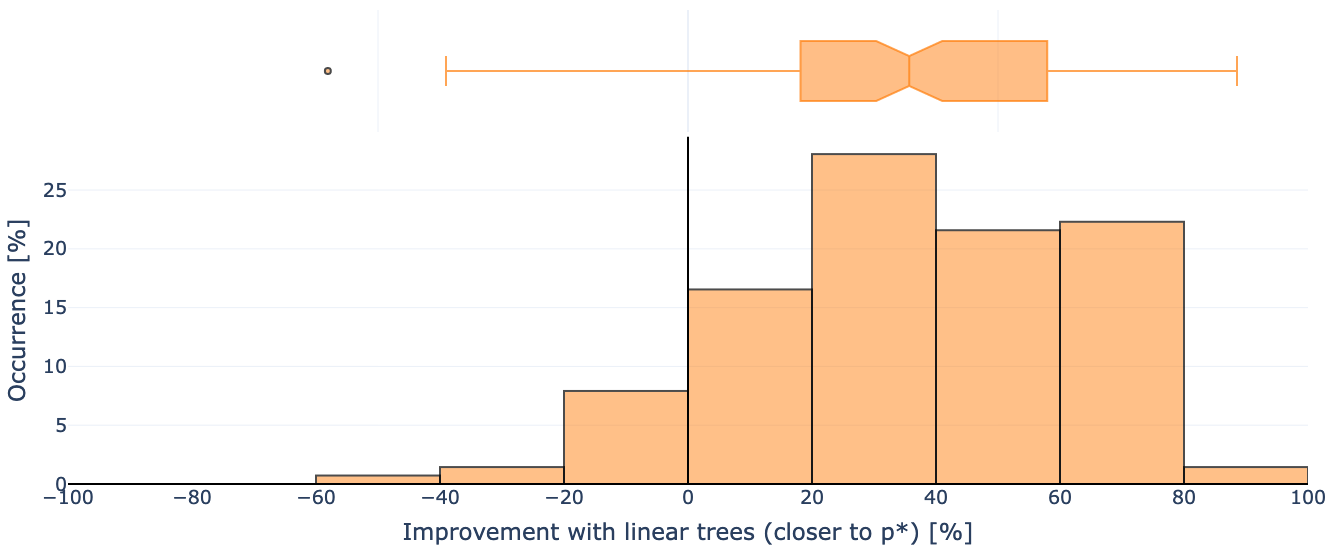

In [30]:
# Plot Score
graph = pd.DataFrame(scores)
graph.drop(columns="member_id", inplace=True)
print(f"Mean value {round(graph.score.mean(), 2)} %")


_fig = px.histogram(graph[graph.score > -100], histnorm="percent", nbins=10, marginal="box")
_fig.update_traces(marker_opacity=0.7, marker_line_color="black", marker_line_width=2,
                   marker_color="rgba(255, 127, 14, 0.7)")

_fig.update_layout(
    layout, yaxis_title="Occurrence [%]",
    height=550,
    width=850,
    xaxis_title="Improvement with linear trees (closer to p*) [%]",
    xaxis_range=[-100, 100],
    xaxis_dtick=20)
_fig.show()

+----------------+--------------+
| features       |   importance |
|----------------+--------------|
| netload_kw     |         0.89 |
| sum_netload_kw |         0.06 |
| epsilon        |         0.05 |
+----------------+--------------+


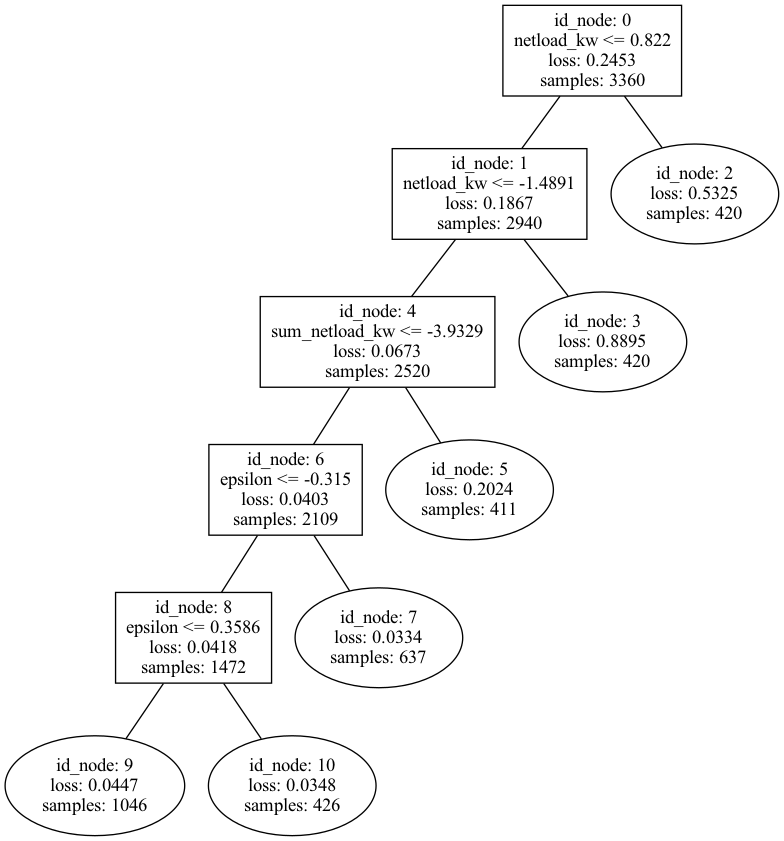

In [29]:
from tabulate import tabulate
def printdf(df):
    print(tabulate(df, headers='keys', tablefmt='psql'))

index = -1

feature_weight = pd.DataFrame(data={"features": features, "importance": models[index].feature_importances_})
feature_weight = feature_weight.sort_values("importance", ascending=False, ignore_index=True)
feature_weight.set_index("features", inplace=True)
printdf(feature_weight.nlargest(3, "importance").round(2))

models[index].plot_model(feature_names=features, max_depth=5)

In [31]:
_fig.write_image("results/adjustment.svg")

In [11]:
#import plotly.graph_objects as go
#__fig = go.Figure(_fig)

#graph = pd.DataFrame(scores)
#graph.drop(columns="member_id", inplace=True)
#print(f"Mean value {round(graph.score.mean(), 2)} %")

#for trace in px.histogram(graph[graph.score > -100], histnorm="percent", nbins=10).data:
    #__fig.add_trace(trace)
    #__fig.data[-1].update(marker_opacity=0.7, marker_line_color="black",
    #                      marker_line_width=2, marker_color="rgba(255, 127, 14, 0.7)")
    #__fig.layout.update(barmode="overlay")
#__fig.show()